In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp -r /content/gdrive/My\ Drive/fer2013.csv /content/

In [0]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

data = pd.read_csv('/content/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [0]:
num_features = 64
num_labels = 7
batch_size = 2048
epochs = 100
width, height = 48, 48

In [0]:
pixels = data['pixels'].tolist() # 1

faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # 2
    face = np.asarray(face).reshape(width, height) # 3
    
    # There is an issue for normalizing images. Just comment out 4 and 5 lines until when I found the solution.
    # face = face / 255.0 # 4
    # face = cv2.resize(face.astype('uint8'), (width, height)) # 5
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1) # 6

emotions = pd.get_dummies(data['emotion']).to_numpy() # 7

In [0]:
newX_tr=[]
newY_tr=[]
import imgaug.augmenters as iaa
import random

for i in range(len(faces)):
  if (np.argmax(emotions[i])==5):
    p= random.uniform(0, 1)
    if(p<0.4):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(faces[i])
      newX_tr.append(noise_image)
      newY_tr.append(emotions[i])
  if (np.argmax(emotions[i])==2):
    p= random.uniform(0, 1)
    if(p<0.2):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(faces[i])
      newX_tr.append(noise_image)
      newY_tr.append(emotions[i])
  if (np.argmax(emotions[i])==0):
    p= random.uniform(0, 1)
    if(p<0.2):
      gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
      noise_image=gaussian_noise.augment_image(faces[i])
      newX_tr.append(noise_image)
      newY_tr.append(emotions[i])
  if (np.argmax(emotions[i])==1):
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(faces[i])
    newX_tr.append(flip_hr_image)
    newY_tr.append(emotions[i])

    con=iaa.LinearContrast((0.5, 2.0), per_channel=0.5)
    con_image = con.augment_image(faces[i])
    newX_tr.append(con_image)
    newY_tr.append(emotions[i])

    con2=iaa.LinearContrast((0.25, 1.0), per_channel=0.25)
    con_image2 = con2.augment_image(faces[i])
    newX_tr.append(con_image2)
    newY_tr.append(emotions[i])

    sh = iaa.Sharpen(alpha=.2, lightness=(0.75, 1.5))
    sh_image = sh.augment_image(faces[i])
    newX_tr.append(sh_image)
    newY_tr.append(emotions[i])

    sh2 = iaa.Sharpen(alpha=.1, lightness=(0.5, 1.25))
    sh_image2 = sh2.augment_image(faces[i])
    newX_tr.append(sh_image2)
    newY_tr.append(emotions[i])

    croped = iaa.Crop(percent=(0, 0.02))
    croped_image = croped.augment_image(faces[i])
    newX_tr.append(croped_image)
    newY_tr.append(emotions[i])

    croped2 = iaa.Crop(percent=(0, 0.01))
    croped_image2 = croped2.augment_image(faces[i])
    newX_tr.append(croped_image2)
    newY_tr.append(emotions[i])

    gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
    noise_image=gaussian_noise.augment_image(faces[i])
    newX_tr.append(noise_image)
    newY_tr.append(emotions[i])

    gaussian_noise2=iaa.AdditiveGaussianNoise(5,10)
    noise_image2=gaussian_noise2.augment_image(faces[i])
    newX_tr.append(noise_image2)
    newY_tr.append(emotions[i])
    
  newX_tr.append(faces[i])
  newY_tr.append(emotions[i])

newX_tr = np.array(newX_tr)
newY_tr = np.array(newY_tr)

In [0]:
print(newX_tr.shape)
print(newY_tr.shape)
emotions=newY_tr
faces=newX_tr

(44452, 48, 48, 1)
(44452, 7)


In [0]:
X_train, X_val, y_train, y_val = train_test_split(faces, emotions, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape)

X_train = X_train / 255.
X_val = X_val / 255.

(32298, 48, 48, 1) (32298, 7)


In [0]:
def plot(training_results, validation_results, results_type, model_name="dexpression"):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)

In [0]:
def model_orig(input_shape=(48,48,1), num_classes=7):
    padding = 'same'
    inp = Input(shape=input_shape)
    # START MODEL
    conv_1 = Conv2D(64, (7, 7), strides=(2, 2), padding=padding, activation='relu', name='conv_1')(inp)
    maxpool_1 = MaxPooling2D((3, 3), strides=(2,2))(conv_1)
    maxpool_1 = Dropout(0.3)(maxpool_1)
    x = BatchNormalization()(maxpool_1)
    
    # FEAT-EX1
    conv_2a = Conv2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_2a')(x)
    conv_2b = Conv2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_2b')(conv_2a)
    maxpool_2a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2a')(x)
    maxpool_2a = Dropout(0.3)(maxpool_2a)
    conv_2c = Conv2D(64, (1, 1), strides=(1,1), name='conv_2c')(maxpool_2a)
    concat_1 = concatenate([conv_2b,conv_2c],axis=3,name='concat_2')
    maxpool_2b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_2b')(concat_1)
    maxpool_2b = Dropout(0.3)(maxpool_2b)
    
    # FEAT-EX2
    conv_3a = Conv2D(96, (1, 1), strides=(1,1), activation='relu', padding=padding, name='conv_3a')(maxpool_2b)
    conv_3b = Conv2D(208, (3, 3), strides=(1,1), activation='relu', padding=padding, name='conv_3b')(conv_3a)
    maxpool_3a = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3a')(maxpool_2b)
    maxpool_3a = Dropout(0.3)(maxpool_3a)
    conv_3c = Conv2D(64, (1, 1), strides=(1,1), name='conv_3c')(maxpool_2a)
    concat_3 = concatenate([conv_3b,conv_3c],axis=3,name='concat_3')
    maxpool_3b = MaxPooling2D((3,3), strides=(1,1), padding=padding, name='maxpool_3b')(concat_3)
    maxpool_3b = Dropout(0.3)(maxpool_3b)

    # FINAL LAYERS
    net = Flatten()(maxpool_3b)
    net = Dense(num_classes, activation='softmax', name='predictions')(net)
    model = Model(inputs = inp, outputs = net)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [0]:
from tensorflow.keras.regularizers import l2
def model_cnn2(input_shape=(48,48,1), num_classes=7) :
  num_features = 64
  model = Sequential()
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes, activation='softmax'))
  model.compile(optimizer =  Adam() , loss = "categorical_crossentropy", metrics=["accuracy"])
  
  return model

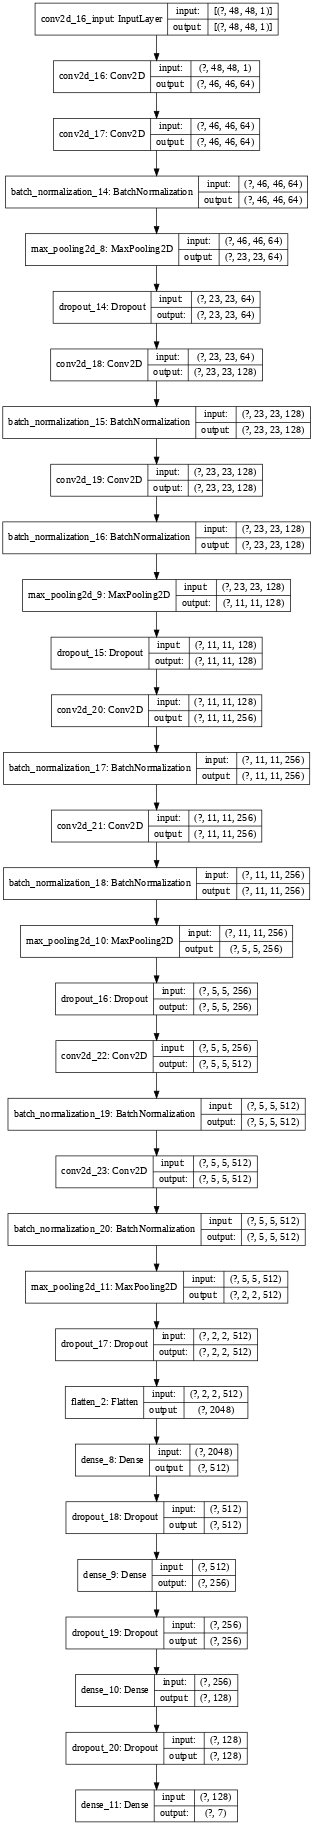

In [0]:
from tensorflow.keras.utils import plot_model
model = model_cnn2()
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model_1.png')

In [0]:
model = model_orig()

In [0]:
import cv2
import math
import joblib
import numpy as np
import pandas as pd


import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model


import tensorflow as tf
from tensorflow.keras.layers import Conv2D,AveragePooling2D, MaxPooling2D, ZeroPadding2D , Activation, BatchNormalization,concatenate ,Flatten,Dropout,Dense
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.optimizers import Adam,Adadelta, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
from keras.utils import np_utils
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Epoch 1/200
157/156 [==============================] - 4s 25ms/step - loss: 2.3338 - accuracy: 0.2424 - val_loss: 1.9590 - val_accuracy: 0.2264 - lr: 0.0010
Epoch 2/200
157/156 [==============================] - 4s 23ms/step - loss: 1.6696 - accuracy: 0.3544 - val_loss: 1.9327 - val_accuracy: 0.2570 - lr: 0.0010
Epoch 3/200
157/156 [==============================] - 4s 23ms/step - loss: 1.5829 - accuracy: 0.3986 - val_loss: 1.7818 - val_accuracy: 0.3114 - lr: 0.0010
Epoch 4/200
157/156 [==============================] - 4s 23ms/step - loss: 1.5440 - accuracy: 0.4146 - val_loss: 1.7302 - val_accuracy: 0.3062 - lr: 0.0010
Epoch 5/200
157/156 [==============================] - 4s 24ms/step - loss: 1.5133 - accuracy: 0.4273 - val_loss: 1.7644 - val_accuracy: 0.3471 - lr: 0.0010
Epoch 6/200
157/156 [==============================] - 4s 24ms/step - loss: 1.4936 - accuracy: 0.4395 - val_loss: 1.6057 - val_accuracy: 0.4146 - lr: 0.0010
Epoch 7/200
157/156 [==============================] - 4s 

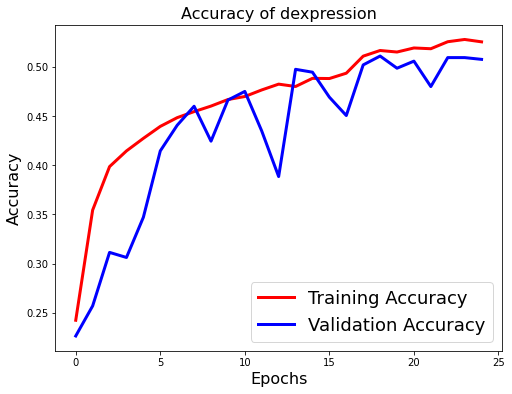

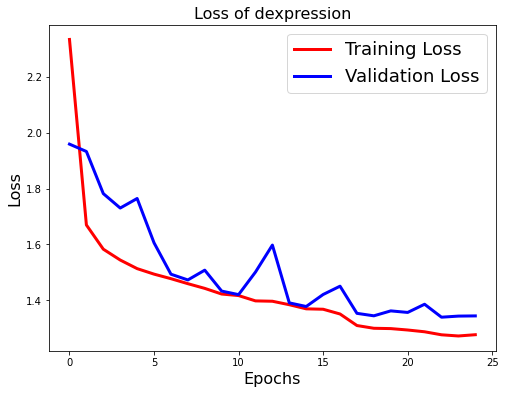

In [0]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=6,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00025,
    factor=0.25,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]
batch_size = 256
epochs = 200#45
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)
model = model_orig()
hist = model.fit(X_train,y_train, batch_size=batch_size,validation_data=( X_val, y_val),
  steps_per_epoch=len(X_train) / batch_size,
  epochs=epochs,
  callbacks=callbacks)
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')

In [0]:
model.save('/content/gdrive/My Drive/model_0.h5')

Epoch 1/200
157/156 [==============================] - 14s 92ms/step - loss: 2.0902 - accuracy: 0.1758 - val_loss: 1.9501 - val_accuracy: 0.2030 - lr: 0.0010
Epoch 2/200
157/156 [==============================] - 13s 85ms/step - loss: 1.9324 - accuracy: 0.2105 - val_loss: 1.9509 - val_accuracy: 0.2030 - lr: 0.0010
Epoch 3/200
157/156 [==============================] - 13s 85ms/step - loss: 1.8638 - accuracy: 0.2383 - val_loss: 1.9983 - val_accuracy: 0.1920 - lr: 0.0010
Epoch 4/200
157/156 [==============================] - 13s 85ms/step - loss: 1.8042 - accuracy: 0.2685 - val_loss: 1.7847 - val_accuracy: 0.2898 - lr: 0.0010
Epoch 5/200
157/156 [==============================] - 13s 85ms/step - loss: 1.6901 - accuracy: 0.3290 - val_loss: 1.5994 - val_accuracy: 0.3813 - lr: 0.0010
Epoch 6/200
157/156 [==============================] - 13s 85ms/step - loss: 1.5642 - accuracy: 0.3959 - val_loss: 1.5617 - val_accuracy: 0.4096 - lr: 0.0010
Epoch 7/200
157/156 [==============================]

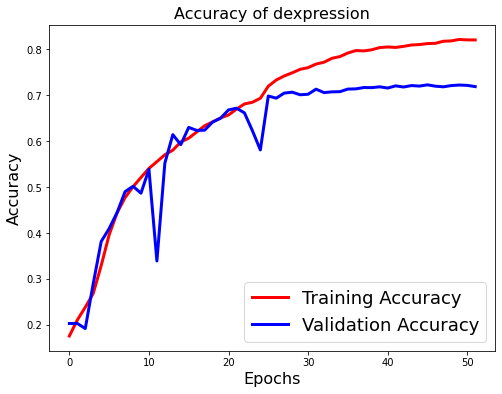

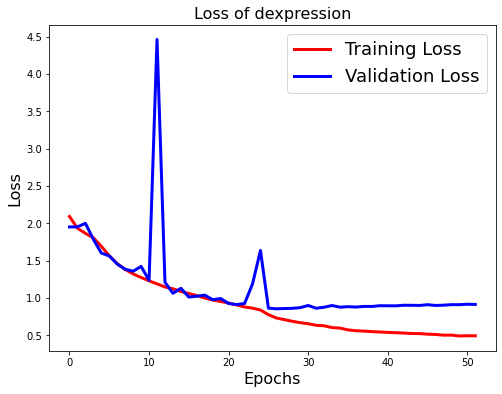

In [0]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=6,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00025,
    factor=0.25,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]
batch_size = 256
epochs = 200#45
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)
model = model_cnn2()
hist = model.fit(X_train,y_train, batch_size=batch_size,validation_data=( X_val, y_val),
  steps_per_epoch=len(X_train) / batch_size,
  epochs=epochs,
  callbacks=callbacks)
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')

In [0]:
model.save('/content/gdrive/My Drive/model_cnn2_72.h5')

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
yhat_valid = model.predict(X_val)
yhat_valid = np.argmax(yhat_valid, axis=1)



print(f'total wrong validation predictions: {np.sum(np.argmax(y_val, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_val, axis=1), yhat_valid))


total wrong validation predictions: 1235


              precision    recall  f1-score   support

           0       0.69      0.57      0.63       624
           1       0.95      0.97      0.96       559
           2       0.60      0.50      0.55       566
           3       0.82      0.87      0.84       903
           4       0.53      0.60      0.56       587
           5       0.83      0.79      0.81       554
           6       0.62      0.69      0.65       655

    accuracy                           0.72      4448
   macro avg       0.72      0.71      0.71      4448
weighted avg       0.72      0.72      0.72      4448



## **Demo**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
def classify(image):
  image=cv2.imread(image)
  dsize = (48, 48)
  output = cv2.resize(image, dsize)
  out=cv2.cvtColor(output, cv2.COLOR_BGR2GRAY).reshape(48,48,1)
  emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
  model_cnn2 = tf.keras.models.load_model('/content/gdrive/My Drive/model_70_7.h5')
  print(out.shape)
  img_hog = output.astype("uint8")
  img_hog = cv2.resize(img_hog, (64,128))
  hog = cv2.HOGDescriptor()
  hog_descr = hog.compute(img_hog)
  hog_descr=np.array(hog_descr)
  print(np.array(hog_descr).shape)
  yhat = model_cnn2.predict([np.array([out]),np.array([hog_descr])])
  label = emotion_label_to_text[np.argmax(yhat)]
  px = image
  plt.imshow(px, cmap='gray')
  plt.xlabel(label, fontsize=18)

In [0]:
def classify2(image):
  emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
  model_cnn2 = tf.keras.models.load_model('/content/model_73_7.h5')
  img_hog = output.astype("uint8")
  img_hog = cv2.resize(img_hog, (64,128))
  hog = cv2.HOGDescriptor()
  hog_descr = hog.compute(img_hog)
  hog_descr=np.array(hog_descr)
  yhat = model_cnn2.predict([np.array([image]),np.array([hog_descr])])
  label = emotion_label_to_text[np.argmax(yhat)]
  px = image.reshape(48, 48).astype('float32')
  plt.imshow(px, cmap='gray')
  plt.xlabel(label, fontsize=18)


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

import scipy.misc
import scipy.stats
from scipy import ndimage

def classifyEnsemble(image):
  image=cv2.imread(image)
  dsize = (48, 48)
  output = cv2.resize(image, dsize)
  out=cv2.cvtColor(output, cv2.COLOR_BGR2GRAY).reshape(48,48,1)
  emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
  model_73 = tf.keras.models.load_model("/content/gdrive/My Drive/model_73_7.h5")
  labels=[]

  model_cnn2 = tf.keras.models.load_model('/content/gdrive/My Drive/model_cnn2_72.h5')

  img_hog = output.astype("uint8")
  img_hog = cv2.resize(img_hog, (64,128))
  hog = cv2.HOGDescriptor()
  hog_descr = hog.compute(img_hog)
  hog_descr=np.array(hog_descr)
  yhat = model_73.predict([np.array([out]),np.array([hog_descr])])
  labels.append(yhat)
  yhat = model_cnn2.predict([np.array([out])])
  labels.append(yhat)
  labels = np.array(labels)
  labels = scipy.stats.mode(labels, axis=1)[0]
  labels = np.squeeze(labels)
  
  label = emotion_label_to_text[np.argmax(labels)]
  px = image
  plt.imshow(px, cmap='gray')
  plt.xlabel(label, fontsize=18)

In [0]:
def classifyEnsemble1(image):
  emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
  model_73 = tf.keras.models.load_model("/content/gdrive/My Drive/model_73_7.h5")
  labels=[]

  model_cnn2 = tf.keras.models.load_model('/content/gdrive/My Drive/model_cnn2_72.h5')

  img_hog = image.astype("uint8")
  img_hog = cv2.resize(img_hog, (64,128))
  hog = cv2.HOGDescriptor()
  hog_descr = hog.compute(img_hog)
  hog_descr=np.array(hog_descr)
  yhat = model_73.predict([np.array([image]),np.array([hog_descr])])
  labels.append(yhat)
  yhat = model_cnn2.predict([np.array([image])])
  labels.append(yhat)
  labels = np.array(labels)
  weights=[0.7338582873344421,0.8728908896446228]
  summed = np.tensordot(labels, weights, axes=((0),(0)))
  result = np.argmax(summed, axis=1)
  label = emotion_label_to_text[np.argmax(result)]
  px = image.reshape(48, 48).astype('float32')
  plt.imshow(px, cmap='gray')
  plt.xlabel(label, fontsize=18)

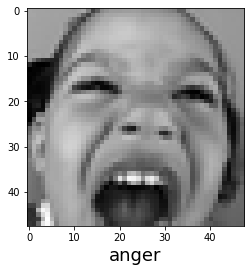

In [0]:
classifyEnsemble1(X_val[12])